In [103]:
import cv2 as cv
import os

## Loading dataset into opencv numpy arrays

In [104]:
# Path of the file containing the images
PATH = 'Dataset'

# Loading all the image paths to count total number of images
import pathlib
# Loading base path of data
data = pathlib.Path(PATH)
# Loading all folders from the base path and the files from them
stuff = list(data.glob('*/*.jpg'))
# Finding the length of the lst, ie; the number of images in total in both folders
len(stuff)

93

In [105]:
# Loading the files paths into a dictionary with labels
files = {'me': [], 'not-me': []}

for dir in data.glob('ME/*.jpg'):
    files['me'].append(dir)
    
for dir in data.glob('NOT-ME/*.jpg'):
    files['not-me'].append(dir)

In [106]:
files['me'][:3], files['not-me'][:3]

([WindowsPath('Dataset/ME/img10.jpg'),
  WindowsPath('Dataset/ME/img12.jpg'),
  WindowsPath('Dataset/ME/img14.jpg')],
 [WindowsPath('Dataset/NOT-ME/IMG-20211003-WA0062.jpg'),
  WindowsPath('Dataset/NOT-ME/IMG-20211003-WA0068.jpg'),
  WindowsPath('Dataset/NOT-ME/IMG-20211004-WA0005.jpg')])

In [107]:
files_labels = {'me': 0, 'not-me': 1}

In [108]:
tuple(list(files.items())[0])

('me',
 [WindowsPath('Dataset/ME/img10.jpg'),
  WindowsPath('Dataset/ME/img12.jpg'),
  WindowsPath('Dataset/ME/img14.jpg'),
  WindowsPath('Dataset/ME/img16.jpg'),
  WindowsPath('Dataset/ME/img18.jpg'),
  WindowsPath('Dataset/ME/img2.jpg'),
  WindowsPath('Dataset/ME/img20.jpg'),
  WindowsPath('Dataset/ME/img22.jpg'),
  WindowsPath('Dataset/ME/img24.jpg'),
  WindowsPath('Dataset/ME/img26.jpg'),
  WindowsPath('Dataset/ME/img28.jpg'),
  WindowsPath('Dataset/ME/img30.jpg'),
  WindowsPath('Dataset/ME/img32.jpg'),
  WindowsPath('Dataset/ME/img34.jpg'),
  WindowsPath('Dataset/ME/img36.jpg'),
  WindowsPath('Dataset/ME/img38.jpg'),
  WindowsPath('Dataset/ME/img4.jpg'),
  WindowsPath('Dataset/ME/img40.jpg'),
  WindowsPath('Dataset/ME/img42.jpg'),
  WindowsPath('Dataset/ME/img44.jpg'),
  WindowsPath('Dataset/ME/img46.jpg'),
  WindowsPath('Dataset/ME/img6.jpg'),
  WindowsPath('Dataset/ME/img8.jpg'),
  WindowsPath('Dataset/ME/IMG_20220128_132447.jpg'),
  WindowsPath('Dataset/ME/IMG_20220128_132448.j

In [109]:
# Loading all the directories as images
img_size = [224, 224]               # Do list instead of tuple (this is done to add the third color channel later with east) but convert to tuple in cv2
x= []
y= []

for label, list_dir in files.items():                       # To extract the key and the value from the dictionary
    for dir in list_dir:
        # print(str(dir))
        img = cv.imread(str(dir))
        img = cv.resize(img, tuple(img_size))
        # Saving the images into x
        x.append(img)
        # Adding in the label
        y.append(files_labels[label])

In [110]:
import numpy as np

print(type(x), type(y))
x = np.array(x)
y= np.array(y)
print(type(x), type(y))

<class 'list'> <class 'list'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [111]:
x[0].shape

(224, 224, 3)

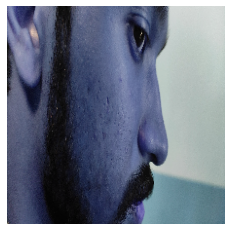

In [112]:
from matplotlib import pyplot as plt
plt.axis('off')
plt.imshow(x[-1])

## Train Test split and Scaling

In [113]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=0, shuffle=True)

In [114]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((65, 224, 224, 3), (65,), (28, 224, 224, 3), (28,))

In [115]:
# Scaling
x_train = x_train / 255
x_test = x_test / 255

In [116]:
import keras
from keras.preprocessing.image import ImageDataGenerator

## Augmentation of the images

In [117]:
train_datagen = ImageDataGenerator(
      rotation_range=10,
      shear_range=0.2,
      horizontal_flip=True,
      vertical_flip=False,
      fill_mode='nearest')

# train_generator is actually an iterator
train_generator = train_datagen.flow(x_train, y_train, batch_size=10)

In [118]:
x_train_final = []
y_train_final = []

for i in range(30):
    images, labels = train_generator.next()
    data = list(zip(images, labels))
    for image, label in data:
        x_train_final.append(image)
        y_train_final.append(label)
print(len(x_train_final), len(y_train_final))
# print(label[0])
# plt.imshow(image[0])

280 280


In [119]:
x_train_final = np.array(x_train_final)
y_train_final = np.array(y_train_final)
# y_train_final = np.expand_dims(y_train_final, axis=0)

In [120]:
np.shape(x_train_final), np.shape(y_train_final)

((280, 224, 224, 3), (280,))

In [121]:
# validation_datagen = ImageDataGenerator(
#       rotation_range=10,
#       shear_range=0.2,
#       horizontal_flip=True,
#       vertical_flip=False,
#       fill_mode='nearest')

# # train_generator is actually an iterator
# val_generator = validation_datagen.flow(x_test, y_test, batch_size=1)

In [122]:
from keras.applications.mobilenet import MobileNet
# Here we load the ResNet model with the trained weights of imagenet but not includeing the final layer as well will add additional layers
# over here to train for our application

res_net_base = MobileNet(input_shape= img_size + [3], weights='imagenet', include_top=False)
# Supplying weights="imagenet" indicates that we want to use the pre-trained ImageNet weights for the respective model.

# Setting all the current layers as non-trainable
for layer in res_net_base.layers:
    layer.trainable = False

In [123]:
"""
"res_net.output" represents the final layer of res_net. We will add additional layers to this layer inorder to add for our situation.
"""
from keras.layers import Dense, GlobalMaxPooling2D

# Here we will be adding a maxPooling layer)
add_layer1 = GlobalMaxPooling2D()

# Adding the final dense layer (only 1 as it is a binary class)
add_layer2 = Dense(1, activation='sigmoid')

# Compiling the model
final_model = keras.Sequential([res_net_base, 
                                add_layer1,
                                add_layer2])

# Displaying the model summary
final_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_max_pooling2d_3 (Glo  (None, 1024)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 3,229,889
Trainable params: 1,025
Non-trainable params: 3,228,864
_________________________________________________________________


## Fitting the model and training

In [124]:
import tensorflow as tf
# tf.keras.losses.BinaryCrossentropy

final_model.compile(
    optimizer='adam',
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [125]:
[x_test.shape, y_test.shape]

[(28, 224, 224, 3), (28,)]

In [126]:
# val_data = np.array((x_test, y_test))

In [127]:
y_test

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1])

### Fitting in the generator

In [128]:
final_model.fit(x_train_final, y_train_final, epochs = 4, batch_size=10, validation_data=(x_test, y_test))

Epoch 1/4
28/28 [==============================] - 7s 181ms/step - loss: 1.0410 - accuracy: 0.6536 - val_loss: 0.2080 - val_accuracy: 0.9286
Epoch 2/4
28/28 [==============================] - 4s 150ms/step - loss: 0.1112 - accuracy: 0.9571 - val_loss: 0.2005 - val_accuracy: 0.9286
Epoch 3/4
28/28 [==============================] - 4s 148ms/step - loss: 0.0491 - accuracy: 0.9857 - val_loss: 0.1274 - val_accuracy: 0.9643
Epoch 4/4
28/28 [==============================] - 4s 147ms/step - loss: 0.0242 - accuracy: 0.9964 - val_loss: 0.1768 - val_accuracy: 0.9286


In [129]:
img_size

[224, 224]

(1, 224, 224, 3)

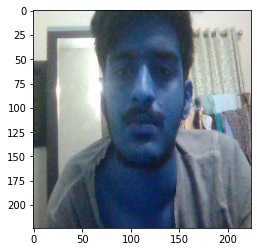

In [134]:
img = cv.resize(cv.imread('fun/img8.jpg'), tuple(img_size))
plt.imshow(img)
img = img/255
img = np.array([img])
img.shape


In [135]:
final_model.predict(img)

array([[0.0044243]], dtype=float32)

In [132]:
if final_model.predict(img) <0.5:
    print("Hello Gokul!!")
else:
    print("Who the hell are you!")

Who the hell are you!


In [136]:
final_model.save(os.path.join('Models', 'Face_MobNets50.h5'))